Compute the normalised HSIC for weights of edges. This normalised statistic corresponds to distance correlation (https://arxiv.org/pdf/1606.07892.pdf): $\rho_{XY} = \frac{\|C_{XY}\|^2_{HS}}{\|C_{XX}\|_{HS}\|C_{YY}\|_{HS}}$

Moreover, in this notebook we precompute the kernel matrices for each continent and each goal.

# d-HSIC Independence test amongst SDGs

Joint Independence test

$H_0: \mathbb{P}_{\mathbf{X}} = \mathbb{P}_{X_1} \mathbb{P}_{X_2} \dots \mathbb{P}_{X_d}$

We compute these depedencies on a goal level. We work with the concatenated time-series, where each country corresponds to an independent sample.

In this notebook we work with groupings of countries according to continents.

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pickle
from sklearn.metrics import pairwise_distances, pairwise_kernels
import networkx as nx
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) 

import pandas as pd

import copy

## Loading standardised imputed data set
We load first of all the standardised imputed data set which we have generated with the previous notebook.

In [2]:
targets_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_i_up_arr_wb.pkl', 'rb'))
goals_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_i_up_arr_wb.pkl', 'rb'))

In [3]:
c = pd.read_csv('/Users/saravallejomengod/MathsYear4/M4R/utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])

groups = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/groups.csv')
groups.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 
                'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
                'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 
                'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', 
                "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', 
                "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 
                'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 
                'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania',
                'United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 
                'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'},
               inplace=True)

info = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/wb_info.csv', header=None)

In [4]:
# removes some countries in-place
countries.remove('Micronesia, Fed. Sts.')
groups['Global South'].drop(index=1, inplace=True)

In [5]:
groups

,Global North,Global South,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),G20,Emerging Markets (BRICS + N-11),OPEC,Low Income,Lower middle Income,Upper middle Income,High Income
0,Albania,Fiji,"Yemen, Rep.",Afghanistan,Antigua and Barbuda,Australia,Bangladesh,Algeria,Afghanistan,Angola,Albania,Antigua and Barbuda
1,Austria,"Micronesia, Fed. Sts.",Afghanistan,Armenia,"Bahamas, The",Canada,"Egypt, Arab Rep.",Angola,Burkina Faso,Bangladesh,Argentina,Australia
2,Belarus,Tonga,Burundi,Azerbaijan,Barbados,Saudi Arabia,Indonesia,Equatorial Guinea,Burundi,Bhutan,Armenia,Austria
3,Belgium,Vanuatu,Angola,Bhutan,Belize,United States,"Iran, Islamic Rep.",Gabon,Central African Republic,Bolivia,Azerbaijan,"Bahamas, The"
4,Bosnia and Herzegovina,Tuvalu,Benin,Bolivia,Comoros,India,Mexico,"Iran, Islamic Rep.",Chad,Cambodia,Belarus,Bahrain
...,...,...,...,...,...,...,...,...,...,...,...,...
133,NaN,Tajikistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,Turkmenistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,NaN,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,NaN,Uzbekistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We generate a list for all unique targets with their corresponding indicators. 

In [6]:
targets = list(info[4].unique())
targets.remove('T')
dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [7]:
#check 
dict_targets['1.2']

['SI.POV.MDIM',
 'SI.POV.MDIM.17',
 'SI.POV.MDIM.17.XQ',
 'SI.POV.MDIM.FE',
 'SI.POV.MDIM.HH',
 'SI.POV.MDIM.IT',
 'SI.POV.MDIM.MA',
 'SI.POV.MDIM.XQ',
 'SI.POV.NAHC',
 'SI.POV.RUHC',
 'SI.POV.URHC']

Similarly, we create a list with all unique SDGs and their corresponding targets.

In [8]:
goals = list(info[3].unique())
goals.remove('T')
dict_goals = {}

for goal in goals:
    g = info[4].where(info[3] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']
    dict_goals[goal] = list(set(dict_goals[goal]))

In [9]:
#check 
print(dict_goals['1'])

['1.2', '1.3', '1.1']


## Data preparation

Since we will work with groupings of countries according to continents, we prepare the data in the following way. We create a dictionary with continents as keys; such that the corresponding value is a 17-vector where each entry corresponds to an SDG. These entries are matrices with each row corresponding to a country.

Moreover, we create a similar second dictionary, such that the entries of the 17-vector of each continent corresponds to the Kernel matrix of such SDG (considered here as a variable). This kernel matrices are computed using a Gaussian kernel with kernel bandwith computed using the median heuristic; and where the independent samples of a variable (SDG) $X^j$ correspond to the different countries of such continent.

In [10]:
def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

In [11]:
def make_K_list(X_list, n_samples, n_nodes):
    """
    Computes the kernel matrices of the variables in X_array, where each column represents one variable.
    Returns a list of the kernel matrices of each variable.
    """
    k_list = list(pairwise_kernels(X_list[i], metric='rbf', gamma=0.5/(width(X_list[i])**2)) for i in range(n_nodes))
    return k_list

In [12]:
warnings.filterwarnings('ignore', category=DeprecationWarning) 

# data preparation
groups_prep_g = {}
groups_prep_g_K = {}

for group in groups:
    print(group)
    
    groups_prep_g[group] = np.empty(17, dtype=object)
    groups_prep_g_K[group] = np.empty(17, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in groups[group].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))
        
        g_array = np.asarray(g_list)
        groups_prep_g[group][g] = g_array
        
        K_matrix = pairwise_kernels(g_array, metric='rbf', gamma=0.5/(width(g_array)**2))
        groups_prep_g_K[group][g] = K_matrix

Global North
Global South
Least Developed Countries (LDC)
Land Locked Developing Countries (LLDC)
Small Island Developing States (SIDS)
G20
Emerging Markets (BRICS + N-11)
OPEC
Low Income
Lower middle Income
Upper middle Income
High Income


In [15]:
# save this data
f = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/groups_prep_g.pkl', 'wb')
pickle.dump(groups_prep_g, f)
f.close()

f = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/groups_prep_g_K.pkl', 'wb')
pickle.dump(groups_prep_g_K, f)
f.close()


In [13]:
# CHECKPOINT
groups_prep_g = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/groups_prep_g.pkl', 'rb'))
groups_prep_g_K = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/groups_prep_g_K.pkl', 'rb'))

## d-HSIC between goals

We compute the d-HSIC on a goal level and perform and independence test.

### Combinations

We need to compute this statistic on all possible d-combinations of the 17 SDGs. Therefore, we create the following functions that given a set and a number r computes all possible combinations without order.

In [14]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [15]:
def combinations_tuple(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

## d-HSIC implementation

In [16]:
def dHSIC(k_list):
    """
    Computes the dHSIC statistic
    """
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    term1, term2, term3 = 1, 1, 2/n_samples    
    for j in range(n_nodes):
        term1 = term1 * k_list[j]
        term2 = term2 * np.sum(k_list[j]) / (n_samples**2)
        term3 = term3 * np.sum(k_list[j], axis=0) / n_samples
    term1_sum = np.sum(term1)
    term3_sum = np.sum(term3)
    dHSIC = term1_sum/(n_samples**2) + term2 - term3_sum
    return dHSIC

In [17]:
def dHSIC_permutation_MC(k_list, n_samples, n_nodes, stat_found, n_perms=5000, alpha=0.05):
    """
    Approximates the null distribution by permutating all variables. Using Monte Carlo approximation.
    """
    # initiating statistics
    statistics = np.zeros(n_perms)
    
    for i in range(n_perms):
        term1 = k_list[0]
        term2 = np.sum(k_list[0])/(n_samples**2)
        term3 = 2 * np.sum(k_list[0], axis=0) / (n_samples**2)

        for j in range(1, n_nodes):
            index_perm = np.random.permutation(k_list[j].shape[0])
            k_perm = k_list[j][index_perm, index_perm[:, None]]

            term1 = term1 * k_perm
            term2 = term2 * np.sum(k_perm) / (n_samples**2)
            term3 = term3 * np.sum(k_perm, axis=0) / n_samples

        term1_sum = np.sum(term1)
        term3_sum = np.sum(term3)

        statistics[i] = term1_sum/(n_samples**2) + term2 - term3_sum
    
    statistics_sort = np.sort(statistics)
    # computing 1-alpha critical value
    Bind = np.sum(stat_found==statistics_sort) + int(np.ceil((1-alpha)*(n_perms+1)))
    critical_value = statistics_sort[Bind]
    
    return critical_value

In [18]:
def joint_independence_test_MC(k_list, n_perms=5000, alpha=0.05):
    """
    Performs the independence test with HSIC and returns an accept or reject statement
    
    Inputs:
    k_list: list of Kernel matrices for each variable, each having dimensions (n_samples, n_samples)  
    n_perms: number of permutations performed when bootstrapping the null
    alpha: rejection threshold of the test
    
    Returns:
    reject: 1 if null rejected, 0 if null not rejected
    
    """
    
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    
    # statistic and threshold
    stat = dHSIC(k_list)
    critical_value = dHSIC_permutation_MC(k_list, n_samples, n_nodes, stat) 
    
    reject = int(stat > critical_value)
    
    return reject

## Algorithm for performing all possible independence tests with dHSIC

In [43]:
def dHSIC_links_MC(group, groups_data, iterable, stop_after_2=False, n_perms=5000, alpha=0.05):
    #For given dictionary groups_data, take nd.array corresponding to group
    # ie. continents_prep_g_K['Europe']
    group_arr = groups_data[group]
    
    K = len(iterable)   #number of total variables (17 goals, 76 targets)
    edges = {}          #initialize dictionary with edges according to dependencies found
    Adj2 = np.zeros((K,K))  #initialize KxK adjacency matrix for d=2
    d = 2   #initial number of variables for dHSIC
    e = 0  
    
    indexes = np.arange(K)    #create vector corresponding to indexes of iterable
    #find all possible d-combinations of indexes without order
    g_combinations = list(combinations_tuple(indexes, d))   
    
    #iterate until no possible combinations of independent variables are left
    while len(g_combinations) >0 :
        print("combinations: ", d)
        print("number of combinations available: ", len(g_combinations))
        
        f = 0
        hsic_found = {}   #initialize dictionary with decision rule for each d-combination considered
        #iterate over all combinations considered
        for comb in g_combinations: 
            #create k_list[i] = Kernel from observed data for variable comb[i]
            k_list = []
            for i in range(d):
                k_list.append(group_arr[comb[i]])
            
            #test joint independence: if reject H0, reject=1 (dependency found)
            reject = joint_independence_test_MC(k_list, n_perms, alpha)   
            
            hsic_found[comb] = reject
            if reject == 1:
                e += 1
                f += 1
                edges[e] = tuple(iterable[i] for i in comb)  #add edge to graph according to dependency found
                if d == 2:
                    Adj2[comb[0], comb[1]] = reject
                    Adj2[comb[1], comb[0]] = reject
                    
        print("Edges found with " ,d, "nodes: ", f)
        
        if stop_after_2==True:
            break
            
        d +=1 #update d
        if d==K+1:
            break #stop iteration if d is greater than available variables
        
        #Find possible d-combinations of iterable. Note that if a dependency has already been found
        #among elements of a combination <d, then we should not consider the combinations involving 
        #these elements
        g_combinations_all = list(combinations_tuple(indexes, d))
        g_combinations = copy.deepcopy(g_combinations_all)

        for comb_n in g_combinations_all:
            #consider all possible sub-combinations of d-1 elements in each comb of g_combinations_all
            gg = list(combinations_tuple(comb_n, d-1)) 
            for l in range(len(gg)):
                # for each sub_combination a dependency among its elements has already been found if 
                # that combination is not in hsic_found (so was already not considered in the previous 
                # step), or if it is but has value = 1 (there was a dependency only for the joint dist 
                # of all d-1 elements)
                if (gg[l] in hsic_found and hsic_found[gg[l]]==1) or (gg[l] not in hsic_found):
                    g_combinations.remove(comb_n)  #do not consider such combination
                    break
                   
    return edges, Adj2

## Experiments on Goal level

Run the above algorithm for finding the high-order dependencies among SDGs in the lowest possible order, ie. starting from pariwise dependencies to d-dependencies.

We do this for the different groupings of countries in our dataset and save the results.

In [44]:
edges_li, Adj2_li = dHSIC_links_MC('Low Income', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  28
combinations:  3
number of combinations available:  351
Edges found with  3 nodes:  18
combinations:  4
number of combinations available:  546
Edges found with  4 nodes:  3
combinations:  5
number of combinations available:  485
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  230
Edges found with  6 nodes:  0
combinations:  7
number of combinations available:  49
Edges found with  7 nodes:  0
combinations:  8
number of combinations available:  2
Edges found with  8 nodes:  0


In [45]:
edges_lmi, Adj2_lmi = dHSIC_links_MC('Lower middle Income', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  44
combinations:  3
number of combinations available:  218
Edges found with  3 nodes:  15
combinations:  4
number of combinations available:  196
Edges found with  4 nodes:  2
combinations:  5
number of combinations available:  76
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  7
Edges found with  6 nodes:  0


In [46]:
edges_umi, Adj2_umi = dHSIC_links_MC('Upper middle Income', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  53
combinations:  3
number of combinations available:  171
Edges found with  3 nodes:  16
combinations:  4
number of combinations available:  126
Edges found with  4 nodes:  4
combinations:  5
number of combinations available:  38
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  3
Edges found with  6 nodes:  0


In [47]:
edges_hi, Adj2_hi = dHSIC_links_MC('High Income', groups_prep_g_K, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  106
combinations:  3
number of combinations available:  17
Edges found with  3 nodes:  2
combinations:  4
number of combinations available:  2
Edges found with  4 nodes:  0


In [48]:
# better save these precious data
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_LI.pkl', 'wb')
pickle.dump(edges_li, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_LMI.pkl', 'wb')
pickle.dump(edges_lmi, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_UMI.pkl', 'wb')
pickle.dump(edges_umi, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_HI.pkl', 'wb')
pickle.dump(edges_hi, hs)
hs.close()

In [49]:
# better save these precious data
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_li.pkl', 'wb')
pickle.dump(Adj2_li, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_lmi.pkl', 'wb')
pickle.dump(Adj2_lmi, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_umi.pkl', 'wb')
pickle.dump(Adj2_umi, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_hi.pkl', 'wb')
pickle.dump(Adj2_hi, hs)
hs.close()

In [22]:
# CHECKPOINT
edges_li = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_LI.pkl', 'rb'))
edges_lmi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_LMI.pkl', 'rb'))
edges_umi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_UMI.pkl', 'rb'))
edges_hi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_HI.pkl', 'rb'))

In [23]:
# CHECKPOINT
Adj2_li = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_li.pkl', 'rb'))
Adj2_lmi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_lmi.pkl', 'rb'))
Adj2_umi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_umi.pkl', 'rb'))
Adj2_hi = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_hi.pkl', 'rb'))

### Compute weights for pairwise relationships found

Use the normalisation of HSIC to compute the weighted adjacency matrix. Normally, one couuld directly compute these when finding the dependencies. We do this after finding them, since we only consideed normalising HSIC after having comuted the aforementioned dependencies. In notebook dHcor_applied, we create a function that both finds dependencies and computes normalisation of HSIC (and dHSIC) at the same time. 

In [24]:
def compute_HSIC_XX(group, groups_data, iterable):
    """Compute HSIC(X,X) for given variable X"""
    group_arr = groups_data[group]
    K = len(iterable)
    indexes = np.arange(K)
    
    #compute individual HSIC_XX
    HSIC_XX_list = []
    for i in indexes:
        k_list_XX = list((group_arr[i], group_arr[i]))
        HSIC_XX = dHSIC(k_list_XX)
        HSIC_XX_list.append(HSIC_XX)
        
    return HSIC_XX_list

In [26]:
#save HSIC(X,X) in a dictionary for all possible goals and all groupings considered
HSIC_XX = {}
HSIC_XX['Low Income'] = compute_HSIC_XX('Low Income', groups_prep_g_K, goals)
HSIC_XX['Lower middle Income'] = compute_HSIC_XX('Lower middle Income', groups_prep_g_K, goals)
HSIC_XX['Upper middle Income'] = compute_HSIC_XX('Upper middle Income', groups_prep_g_K, goals)
HSIC_XX['High Income'] = compute_HSIC_XX('High Income', groups_prep_g_K, goals)

In [61]:
def compute_weighted_matrix(group, groups_data, Adj):
    """For given adjacency matrix, compute weights corresponding to normalisation of dHSIC"""
    Adj_w = copy.deepcopy(Adj)
    (a,b) = Adj.shape
    
    group_arr = groups_data[group]
    
    for i in range(17):
        for j in range(17):
            if Adj[i,j]==1.0:
                k_list = [group_arr[i], group_arr[j]]
                val = dHSIC(k_list)
                Adj_w[i,j] = val/np.sqrt(HSIC_XX[group][i]*HSIC_XX[group][j])
                
    return Adj_w

In [62]:
#weighted networks
Adj2_li_w = compute_weighted_matrix('Low Income', groups_prep_g_K, Adj2_li)
Adj2_lmi_w = compute_weighted_matrix('Lower middle Income', groups_prep_g_K, Adj2_lmi)
Adj2_umi_w = compute_weighted_matrix('Upper middle Income', groups_prep_g_K, Adj2_umi)
Adj2_hi_w = compute_weighted_matrix('High Income', groups_prep_g_K, Adj2_hi)

In [64]:
# better save these precious data
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_li_w.pkl', 'wb')
pickle.dump(Adj2_li_w, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_lmi_w.pkl', 'wb')
pickle.dump(Adj2_lmi_w, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_umi_w.pkl', 'wb')
pickle.dump(Adj2_umi_w, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_hi_w.pkl', 'wb')
pickle.dump(Adj2_hi_w, hs)
hs.close()

In [ ]:
# CHECKPOINT
Adj2_li_w = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_li_w.pkl', 'rb'))
Adj2_lmi_w = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_lmi_w.pkl', 'rb'))
Adj2_umi_w = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_umi_w.pkl', 'rb'))
Adj2_hi_w = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/Adj2_hi_w.pkl', 'rb'))

## Visualisation

In [50]:
!pip install hypernetx

%load_ext autoreload
%autoreload 2
import hypernetx as hnx

In [51]:
from hypernetx.algorithms.s_centrality_measures import *

### Low Income

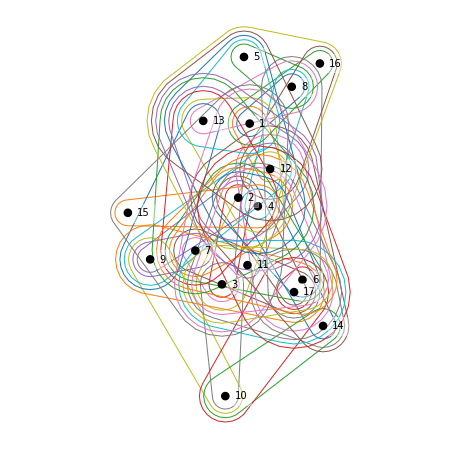

In [52]:
#hypergraph
H_li = hnx.Hypergraph(edges_li)
hnx.draw(H_li, with_edge_labels=False)

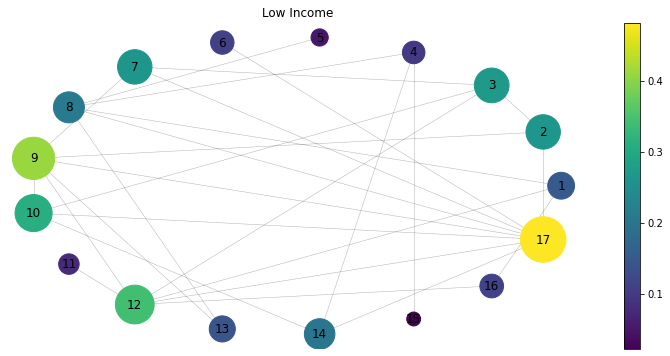

In [53]:
#graph with only 2-way dependencies
G2_li = nx.Graph(Adj2_li)     #define graph
pos2_li = nx.circular_layout(G2_li)  # compute graph layout

#plot
plot_network(G2_li, pos2_li, n_labels, 'Low Income', weights=False, eigenvector_centrality=True)

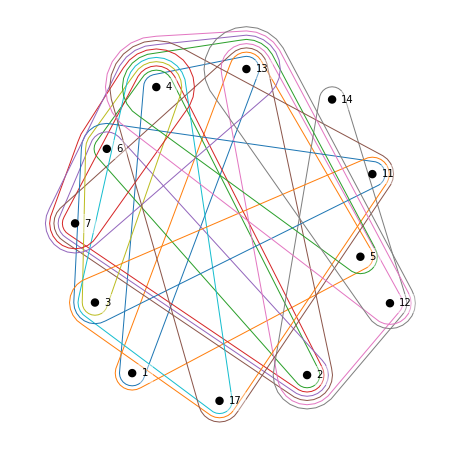

In [71]:
H_li_restrict_edges3 = H_li.restrict_to_edges(list(e for e in edges_li if len(edges_li[e])==3))
hnx.draw(H_li_restrict_edges3, pos=nx.spring_layout(H_li_restrict_edges3), with_edge_labels=False)

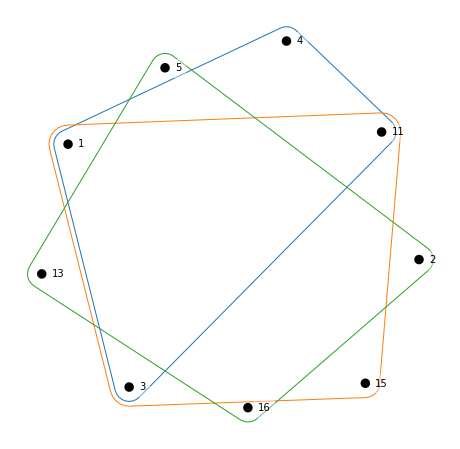

In [72]:
H_li_restrict_edges4 = H_li.restrict_to_edges(list(e for e in edges_li if len(edges_li[e])==4))
hnx.draw(H_li_restrict_edges4, pos=nx.spring_layout(H_li_restrict_edges4), with_edge_labels=False)

In [56]:
centr_li = s_betweenness_centrality(H_li, s=1, normalized=True)

In [57]:
centr_li

{1: 0.005766454659128191,
 2: 0.011029911154506848,
 3: 0.001800958760178618,
 4: 0.013332324270781522,
 5: 0.009030705359970644,
 6: 0.016292439869066075,
 7: 0.00907578785984601,
 8: 0.013438322561422187,
 9: 0.01668463750784653,
 10: 0.010945471008559476,
 11: 0.01362571480770216,
 12: 0.0009329618372171563,
 13: 0.0020601838809447604,
 14: 0.006127241306906365,
 15: 0.00805014857384275,
 16: 0.011326806212787189,
 17: 0.006828035955977686,
 18: 0.022346234332236297,
 19: 0.0069266112301069925,
 20: 0.014487242898149132,
 21: 0.01553502377334951,
 22: 0.015604165062341241,
 23: 0.002748449137026964,
 24: 0.008682265039872822,
 25: 0.006996187659822215,
 26: 0.0034551141010075183,
 27: 0.025629615391346033,
 28: 0.0062689428380917735,
 29: 0.024591467899489076,
 30: 0.010394474271091619,
 31: 0.015876765464593663,
 32: 0.01783047375590069,
 33: 0.008966433284357042,
 34: 0.01642105419794826,
 35: 0.021541714593954066,
 36: 0.02960435829736546,
 37: 0.014146276594343681,
 38: 0.037165

### Lower middle Income

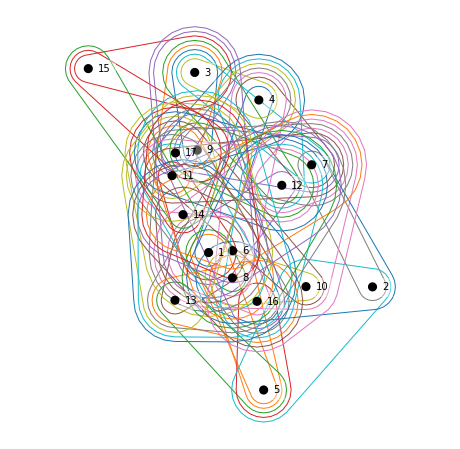

In [58]:
#hypergtraph
H_lmi = hnx.Hypergraph(edges_lmi)
hnx.draw(H_lmi, with_edge_labels=False)

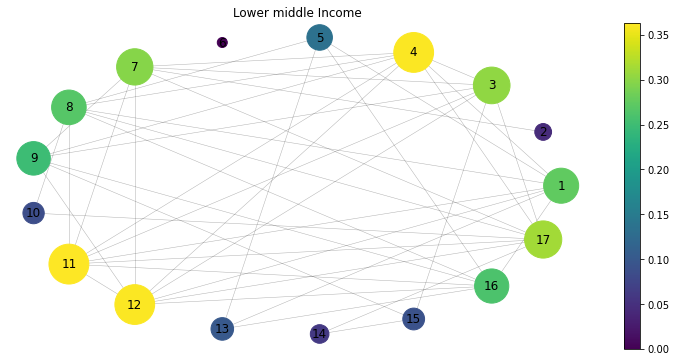

In [59]:
#graph with only 2-way dependencies
G2_lmi = nx.Graph(Adj2_lmi)     #define graph
pos2_lmi = nx.circular_layout(G2_lmi)  # compute graph layout

#plot
plot_network(G2_lmi, pos2_lmi, n_labels, 'Lower middle Income', weights=False, eigenvector_centrality=True)

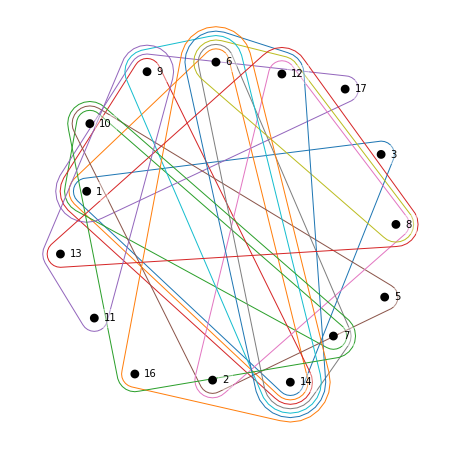

In [69]:
H_lmi_restrict_edges3 = H_lmi.restrict_to_edges(list(e for e in edges_lmi if len(edges_lmi[e])==3))
hnx.draw(H_lmi_restrict_edges3, pos=nx.spring_layout(H_lmi_restrict_edges3), with_edge_labels=False)

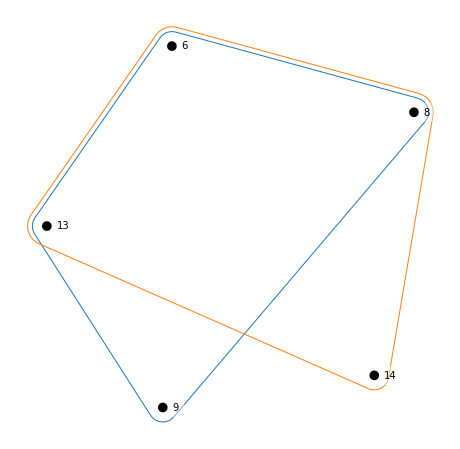

In [70]:
H_lmi_restrict_edges4 = H_lmi.restrict_to_edges(list(e for e in edges_lmi if len(edges_lmi[e])==4))
hnx.draw(H_lmi_restrict_edges4, pos=nx.spring_layout(H_lmi_restrict_edges4), with_edge_labels=False)

### Upper middle Income

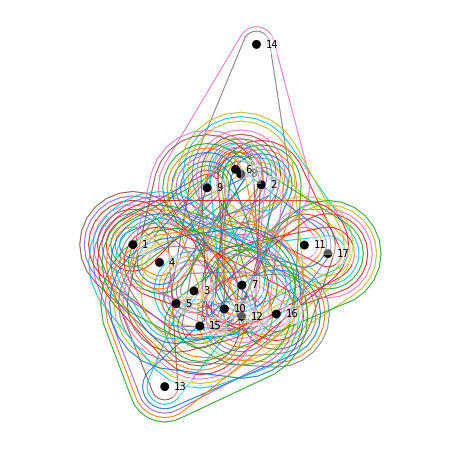

In [60]:
#hypergraph
H_umi = hnx.Hypergraph(edges_umi)
hnx.draw(H_umi, with_edge_labels=False)

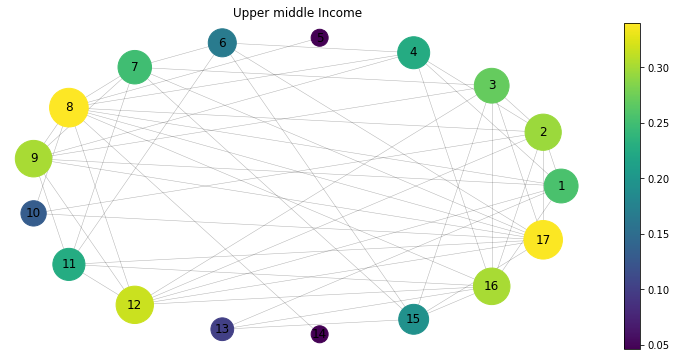

In [61]:
#graph with only 2-way dependencies
G2_umi = nx.Graph(Adj2_umi)     #define graph
pos2_umi = nx.circular_layout(G2_umi)  # compute graph layout

#plot
plot_network(G2_umi, pos2_umi, n_labels, 'Upper middle Income', weights=False, eigenvector_centrality=True)

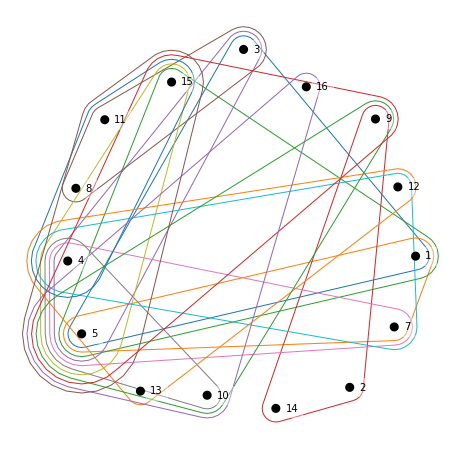

In [67]:
H_umi_restrict_edges3 = H_umi.restrict_to_edges(list(e for e in edges_umi if len(edges_umi[e])==3))
hnx.draw(H_umi_restrict_edges3, pos=nx.spring_layout(H_umi_restrict_edges3), with_edge_labels=False)

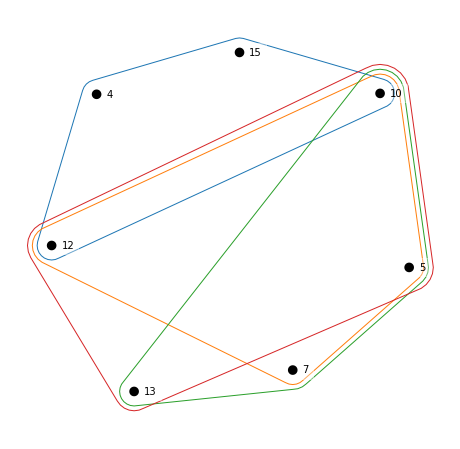

In [68]:
H_umi_restrict_edges4 = H_umi.restrict_to_edges(list(e for e in edges_umi if len(edges_umi[e])==4))
hnx.draw(H_umi_restrict_edges4, pos=nx.spring_layout(H_umi_restrict_edges4), with_edge_labels=False)

### High Income

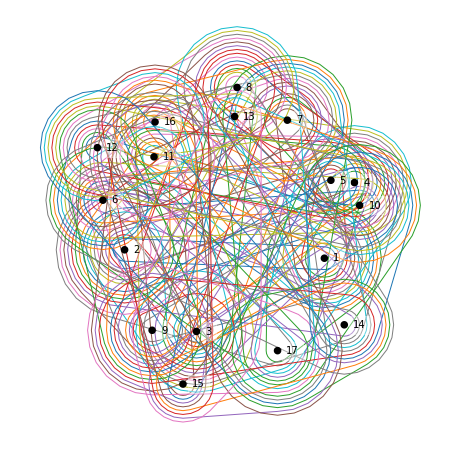

In [62]:
#hypergraph
H_hi = hnx.Hypergraph(edges_hi)
hnx.draw(H_hi, with_edge_labels=False)

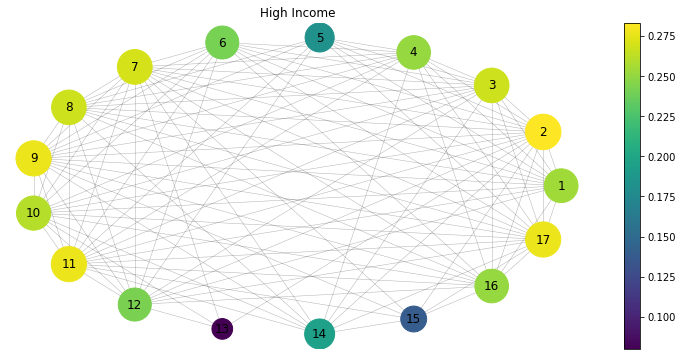

In [63]:
#graph with only 2-way dependencies
G2_hi = nx.Graph(Adj2_hi)     #define graph
pos2_hi = nx.circular_layout(G2_hi)  # compute graph layout

#plot
plot_network(G2_hi, pos2_hi, n_labels, 'High Income', weights=False, eigenvector_centrality=True)

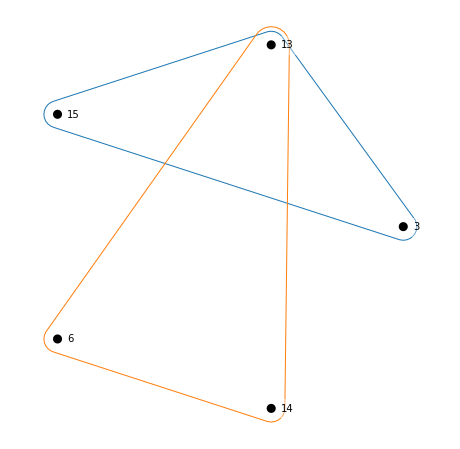

In [64]:
H_hi_restrict_edges3 = H_hi.restrict_to_edges(list(e for e in edges_hi if len(edges_hi[e])==3))
hnx.draw(H_hi_restrict_edges3, pos=nx.circular_layout(H_hi_restrict_edges3), with_edge_labels=False)